Compared to 1.0:
- Scale the features to mean 0 and var 1:
    - Train set: scale features & target respectively. Train model using scaled features and scaled target. Use the mean and variance of target to unscale the forecasted values
    - Test set: scale features (i.e., the previous N days value). Use the mean and variance of previous N days AdjClose to unscale the forecasted values

## Load packages and parameter configuration

In [95]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from datetime import date
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("fivethirtyeight")

start_date = '2015-11-25' # Data start date (inclusive)
end_date = '2018-11-24' # Data end date (exclusive)
path = f'./data/VTI_{start_date}_{end_date}' # Path of downloaded data file
N = 7

## Load data

In [2]:
X_train = pd.read_csv(f'{path}/X_train.csv')
y_train = pd.read_csv(f'{path}/y_train.csv')

X_cv = pd.read_csv(f'{path}/X_cv.csv')
y_cv = pd.read_csv(f'{path}/y_cv.csv')

X_test = pd.read_csv(f'{path}/X_test.csv')
y_test = pd.read_csv(f'{path}/y_test.csv')

In [35]:
df_train = pd.read_csv(f'{path}/df_train.csv')
df_cv = pd.read_csv(f'{path}/df_cv.csv')
df_test = pd.read_csv(f'{path}/df_test.csv')

# Convert data type
df_train['Date'] = pd.to_datetime(df_train['Date'])
df_cv['Date'] = pd.to_datetime(df_cv['Date'])
df_test['Date'] = pd.to_datetime(df_test['Date'])

In [99]:
df_train.head()

,Date,AdjClose,Volume,Month,DayOfMonth,DayOfWeek,Diff_HighLow,Diff_OpenClose,AdjClose_Lag1,Diff_HighLow_Lag1,...,Diff_OpenClose_Lag5,Volume_Lag5,AdjClose_Lag6,Diff_HighLow_Lag6,Diff_OpenClose_Lag6,Volume_Lag6,AdjClose_Lag7,Diff_HighLow_Lag7,Diff_OpenClose_Lag7,Volume_Lag7
0,2015-12-07,93.652115,3000500,12,7,0,1.209999,0.680000,94.390442,1.919998,...,0.610001,3618100.0,94.601395,0.540001,-0.040001,552400.0,94.460785,0.410004,0.040001,1820300.0
1,2015-12-08,93.089622,3149600,12,8,1,1.130005,0.029999,93.652115,1.209999,...,-0.590004,2443600.0,94.197067,0.739998,0.610001,3618100.0,94.601395,0.540001,-0.040001,552400.0
2,2015-12-09,92.289764,4179800,12,9,2,2.269997,0.550003,93.089622,1.130005,...,1.049995,2937200.0,95.084846,0.839996,-0.590004,2443600.0,94.197067,0.739998,0.610001,3618100.0
3,2015-12-10,92.562263,3684900,12,10,3,1.139999,-0.129997,92.289764,2.269997,...,1.840004,3345600.0,94.091621,1.389999,1.049995,2937200.0,95.084846,0.839996,-0.590004,2443600.0
4,2015-12-11,90.742813,5100700,12,11,4,1.360001,0.930000,92.562263,1.139999,...,-1.580002,4520000.0,92.685295,2.420006,1.840004,3345600.0,94.091621,1.389999,1.049995,2937200.0


## Scaling

### Scaling training set

In [64]:
# Create copy for scaling
df_train_copy = df_train.copy()
df_train_copy = df_train_copy.drop(['Date','Volume','Month','DayOfMonth','DayOfWeek','Diff_HighLow','Diff_OpenClose'],axis=1)

# Apply scaler
scaler = StandardScaler()
scaled_train = scaler.fit_transform(df_train_copy)

# Convert the numpy array back into pandas dataframe
scaled_train = pd.DataFrame(scaled_train, columns=df_train_copy.columns)
scaled_train['Date'] = df_train.reset_index()['Date']

# Store the parameters to unscale
target_mean = scaler.mean_[0] # The first col is the target
target_var = scaler.var_[0]
unscale_params = {'Train': pd.DataFrame({'Dataset':['Train'],'Mean':[target_mean],'Variance':[target_var]})}

scaled_train.head()


,AdjClose,AdjClose_Lag1,Diff_HighLow_Lag1,Diff_OpenClose_Lag1,Volume_Lag1,AdjClose_Lag2,Diff_HighLow_Lag2,Diff_OpenClose_Lag2,Volume_Lag2,AdjClose_Lag3,...,Volume_Lag5,AdjClose_Lag6,Diff_HighLow_Lag6,Diff_OpenClose_Lag6,Volume_Lag6,AdjClose_Lag7,Diff_HighLow_Lag7,Diff_OpenClose_Lag7,Volume_Lag7,Date
0,-0.885586,-0.801604,2.144550,-2.655396,1.377470,-0.983962,3.143957,3.114915,0.532721,-0.826449,...,0.722210,-0.759961,-0.740740,-0.052027,-1.473118,-0.771943,-1.006815,0.079123,-0.565826,2015-12-07
1,-0.946860,-0.882233,0.667256,1.185068,0.287654,-0.797346,2.113965,-2.633661,1.375073,-0.980731,...,-0.121218,-0.804652,-0.327309,1.034935,0.723238,-0.756365,-0.738365,-0.054858,-1.474690,2015-12-08
2,-1.033990,-0.943661,0.500812,0.080508,0.394591,-0.878151,0.651401,1.165103,0.285194,-0.793666,...,0.233244,-0.706524,-0.120593,-0.971767,-0.118208,-0.801161,-0.325363,1.033716,0.722884,2015-12-09
3,-1.004306,-1.031010,2.872792,0.964161,1.133472,-0.939711,0.486617,0.072537,0.392138,-0.874665,...,0.526523,-0.816307,1.016367,1.770714,0.235421,-0.702801,-0.118862,-0.975963,-0.119028,2015-12-10
4,-1.202502,-1.001252,0.521607,-0.191376,0.778519,-1.027249,2.834945,0.946595,1.131061,-0.936374,...,1.369879,-0.971752,3.145584,3.091802,0.528011,-0.812844,1.016917,1.770587,0.234797,2015-12-11


### Scaling test set

In [38]:
# Features to calculate mean and std
cols = ['AdjClose','Diff_HighLow','Diff_OpenClose','Volume']

for col in cols:
    lag_cols = [f"{col}_Lag{str(i)}" for i in range(1,N+1)]
    df_test[f"{col}_LagsMean"] = df_test[lag_cols].mean(axis=1)
    df_test[f"{col}_LagsStd"] = df_test[lag_cols].std(axis=1)

In [39]:
df_test.head()

,Date,AdjClose,Volume,Month,DayOfMonth,DayOfWeek,Diff_HighLow,Diff_OpenClose,AdjClose_Lag1,Diff_HighLow_Lag1,...,Diff_OpenClose_Lag7,Volume_Lag7,AdjClose_LagsMean,AdjClose_LagsStd,Diff_HighLow_LagsMean,Diff_HighLow_LagsStd,Diff_OpenClose_LagsMean,Diff_OpenClose_LagsStd,Volume_LagsMean,Volume_LagsStd
0,2018-04-25,125.392487,2275400,4,25,2,1.639999,-0.179993,125.254158,3.330002,...,-0.180008,2892600.0,127.230582,1.131296,1.502858,0.848188,0.518568,0.916780,2.489657e+06,8.756977e+05
1,2018-04-26,126.582306,1284600,4,26,3,1.429993,-0.720001,125.392487,1.639999,...,-0.440002,2219900.0,126.997363,1.331326,1.568573,0.836747,0.518570,0.916778,2.401486e+06,8.592829e+05
2,2018-04-27,126.665329,1133600,4,27,4,0.940002,0.209991,126.582306,1.429993,...,0.179993,1554400.0,126.743056,1.189584,1.615714,0.814961,0.478570,0.970128,2.267871e+06,9.591397e+05
3,2018-04-30,125.742935,2277100,4,30,0,1.740005,1.360001,126.665329,0.940002,...,0.379990,4003900.0,126.475580,0.892124,1.641427,0.785780,0.482856,0.968655,2.207757e+06,1.022410e+06
4,2018-05-01,125.936676,1762700,5,1,1,1.480011,-0.500000,125.742935,1.740005,...,1.059998,1669600.0,126.176472,0.687167,1.724287,0.756590,0.622857,1.020731,1.961071e+06,6.613912e+05


In [68]:
# Add unscale parameters of test set to the dictionary
unscale_params['Test'] = df_test[['Date','AdjClose_LagsMean','AdjClose_LagsStd']]

In [63]:
# Create copy for scaling
df_test_copy = df_test.copy()
df_test_copy = df_test_copy.drop(['Date','Volume','Month','DayOfMonth','DayOfWeek','Diff_HighLow','Diff_OpenClose'],axis=1)

scaled_test = df_test[['Date']]
for col in cols:
    lag_cols = [f"{col}_Lag{str(i)}" for i in range(1,N+1)]
    scaled_temp = df_test_copy[lag_cols].sub(df_test_copy[f'{col}_LagsMean'],axis=0).div(df_test_copy[f'{col}_LagsStd'],axis=0)
    scaled_test = pd.concat([scaled_test,scaled_temp],axis=1)
    
scaled_test.head()


,Date,AdjClose_Lag1,AdjClose_Lag2,AdjClose_Lag3,AdjClose_Lag4,AdjClose_Lag5,AdjClose_Lag6,AdjClose_Lag7,Diff_HighLow_Lag1,Diff_HighLow_Lag2,...,Diff_OpenClose_Lag5,Diff_OpenClose_Lag6,Diff_OpenClose_Lag7,Volume_Lag1,Volume_Lag2,Volume_Lag3,Volume_Lag4,Volume_Lag5,Volume_Lag6,Volume_Lag7
0,2018-04-25,-1.747045,-0.401823,-0.361083,0.535767,1.155380,1.000512,-0.181708,2.154173,-0.180210,...,-0.369309,-1.045583,-0.761988,0.643878,-0.520679,-0.936461,1.729184,-1.068014,-0.308048,0.460139
1,2018-04-26,-1.205472,-1.309375,-0.166272,-0.131653,0.630446,1.156963,1.025364,0.085362,2.105090,...,-0.151160,-0.369312,-1.045588,-0.146734,0.758789,-0.428015,-0.851740,1.864827,-0.985805,-0.211322
2,2018-04-27,-0.135131,-1.135329,-1.251612,0.027694,0.066438,0.919343,1.508596,-0.227890,0.029800,...,0.599330,-0.101616,-0.307771,-1.025160,0.007849,0.819097,-0.244147,-0.623758,1.809985,-0.743866
3,2018-04-30,0.212693,0.119631,-1.214062,-1.369118,0.336748,0.388410,1.525699,-0.892648,-0.269076,...,-0.157800,0.595818,-0.106195,-1.050613,-0.902923,0.066160,0.827206,-0.170242,-0.526362,1.756774
4,2018-05-01,-0.630905,0.711409,0.590590,-1.140896,-1.342198,0.872464,0.939536,0.020776,-1.036604,...,1.643083,-0.286908,0.428262,0.477824,-1.251107,-1.022801,0.475254,1.651713,0.109812,-0.440694


## Split into X and y

In [87]:
target = ['AdjClose']

scaled_X_train = scaled_train.drop(['AdjClose','Date'],axis=1)
scaled_y_train = scaled_train[target]

# Align the columne order with the training set
scaled_X_test = pd.DataFrame()
for i in range(1, N+1):
    for col in cols:
        scaled_X_test=pd.concat([scaled_X_test, scaled_test[f"{col}_Lag{str(i)}"]],axis=1)

## Model training

In [73]:
n_estimators = 100             
max_depth = 3                  
learning_rate = 0.1            
min_child_weight = 1           
subsample = 1                  
colsample_bytree = 1           
colsample_bylevel = 1          
train_test_split_seed = 111    
model_seed = 100

In [74]:
# Initialize the model
model = XGBRegressor(seed=model_seed,
                      n_estimators=n_estimators,
                      max_depth=max_depth,
                      learning_rate=learning_rate,
                      min_child_weight=min_child_weight)

# Train the regressor
model.fit(scaled_X_train, scaled_y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [75]:
def evaluate_model(y_true, y_pred):
    """
    Input: true y and predicted y
    Return: Dataframe of RMSE and MAPE
    """
    rmse = mean_squared_error(y_true, y_pred)**0.5 # root mean squared error
    mape = mean_absolute_percentage_error(y_true, y_pred) # mean absolute percentage error
    
    evaluation = pd.DataFrame({'RMSE':[rmse],'MAPE':[mape]})
    return evaluation

### Performance on training set

In [81]:
# Predict on train set
y_pred = model.predict(scaled_X_train)

mean = unscale_params['Train']['Mean'][0]
var = unscale_params['Train']['Variance'][0]
unscaled_y_pred = y_pred*var**0.5+mean

evaluate_model(y_train, unscaled_y_pred)

,RMSE,MAPE
0,0.350142,0.002557


### Performance on test set

In [92]:
# Predict on test set
y_pred = model.predict(scaled_X_test)
df_test['y_pred'] = y_pred
df_test['unscaled_y_pred'] = df_test['y_pred']*df_test['AdjClose_LagsStd'] + df_test['AdjClose_LagsMean']

evaluate_model(y_test, df_test['unscaled_y_pred'])

,RMSE,MAPE
0,1.11507,0.006063


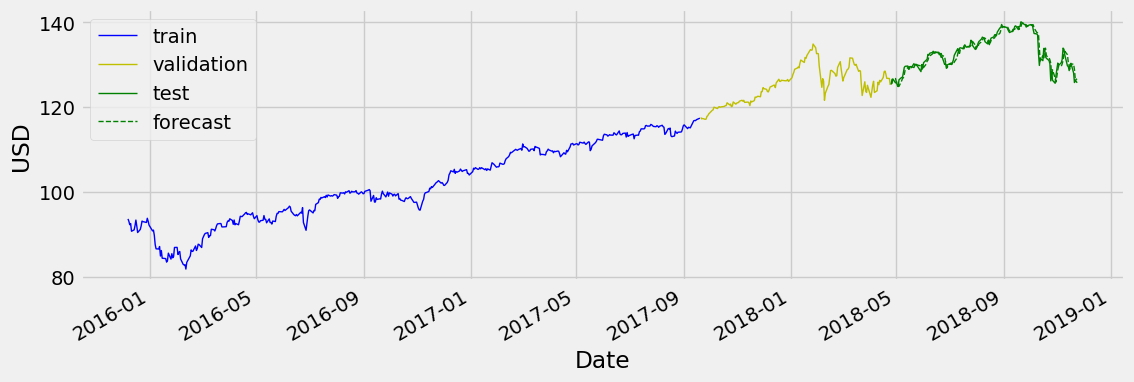

In [93]:
fig, ax = plt.subplots(figsize=(12,4))

df_train.plot(x='Date', y='AdjClose', style='b', linewidth=1, ax=ax)
df_cv.plot(x='Date', y='AdjClose', style='y', linewidth=1, ax=ax)
df_test.plot(x='Date', y='AdjClose', style='g', linewidth=1, ax=ax)
df_test.plot(x='Date', y='unscaled_y_pred', style='g', linestyle='dashed', linewidth=1, ax=ax)

ax.legend(['train','validation','test','forecast'])
ax.set_xlabel('Date')
ax.set_ylabel('USD')

plt.show()

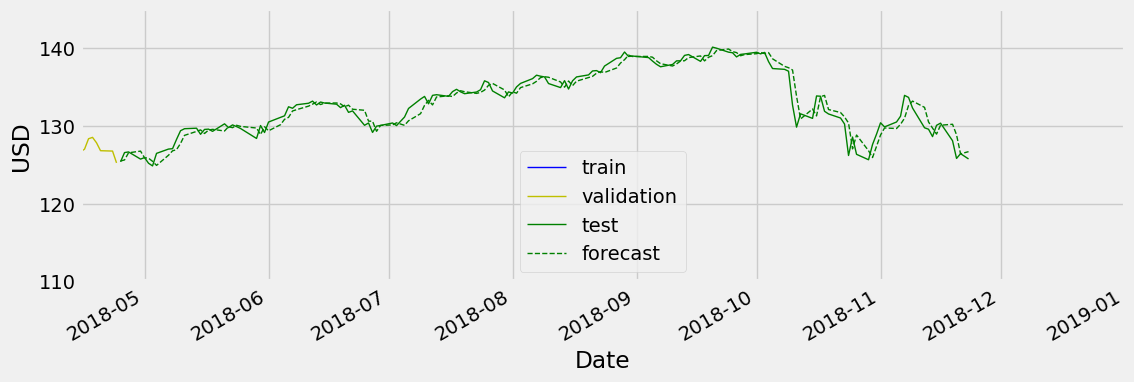

In [98]:
fig, ax = plt.subplots(figsize=(12,4))

df_train.plot(x='Date', y='AdjClose', style='b', linewidth=1, ax=ax)
df_cv.plot(x='Date', y='AdjClose', style='y', linewidth=1, ax=ax)
df_test.plot(x='Date', y='AdjClose', style='g', linewidth=1, ax=ax)
df_test.plot(x='Date', y='unscaled_y_pred', style='g', linestyle='dashed', linewidth=1, ax=ax)

ax.legend(['train','validation','test','forecast'])
ax.set_xlabel('Date')
ax.set_ylabel('USD')
ax.set_xlim([date(2018, 4, 15), date(2019, 1, 1)])
ax.set_ylim(110, 145)

plt.show()